<a href="https://colab.research.google.com/github/kuwaitikiwi/edgered-interview/blob/main/EdgeRed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')
palette = 'viridis'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

clients = pd.read_csv('https://raw.githubusercontent.com/kuwaitikiwi/edgered-interview/main/Clients.csv')
df = pd.read_csv('https://raw.githubusercontent.com/kuwaitikiwi/edgered-interview/main/Payments.csv')
print(len(df))
#assign the corresponding entity_type, entity_year_established for each client_id in each row of the raw dataframe
df['entity_type'] = df['client_id'].map(clients['entity_type'])
df['entity_year_established'] = df['client_id'].map(clients['entity_year_established'])

df.transaction_date = df.transaction_date.apply(lambda test: dt.datetime.fromtimestamp(test).strftime('%Y-%m-%d %H:%M:%S'))

df = df.drop_duplicates(subset=['transaction_date','payment_amt','client_id','payment_code'])
print(len(df))

25559
25366


<Axes: >

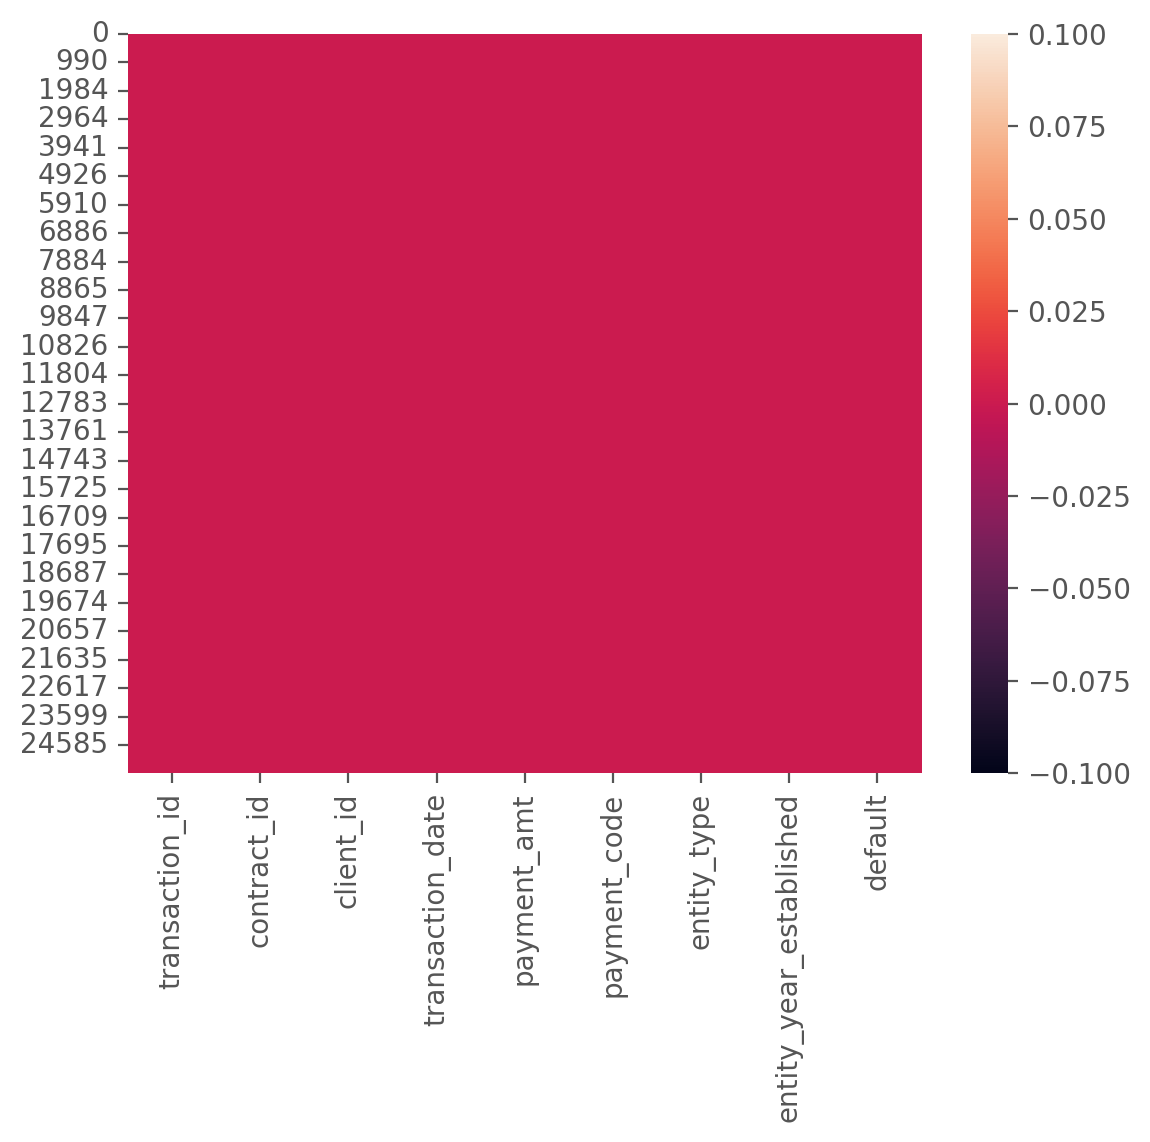

In [34]:
df.dropna(inplace=True)
sns.heatmap(df.isnull(), cbar=True)

## EDA

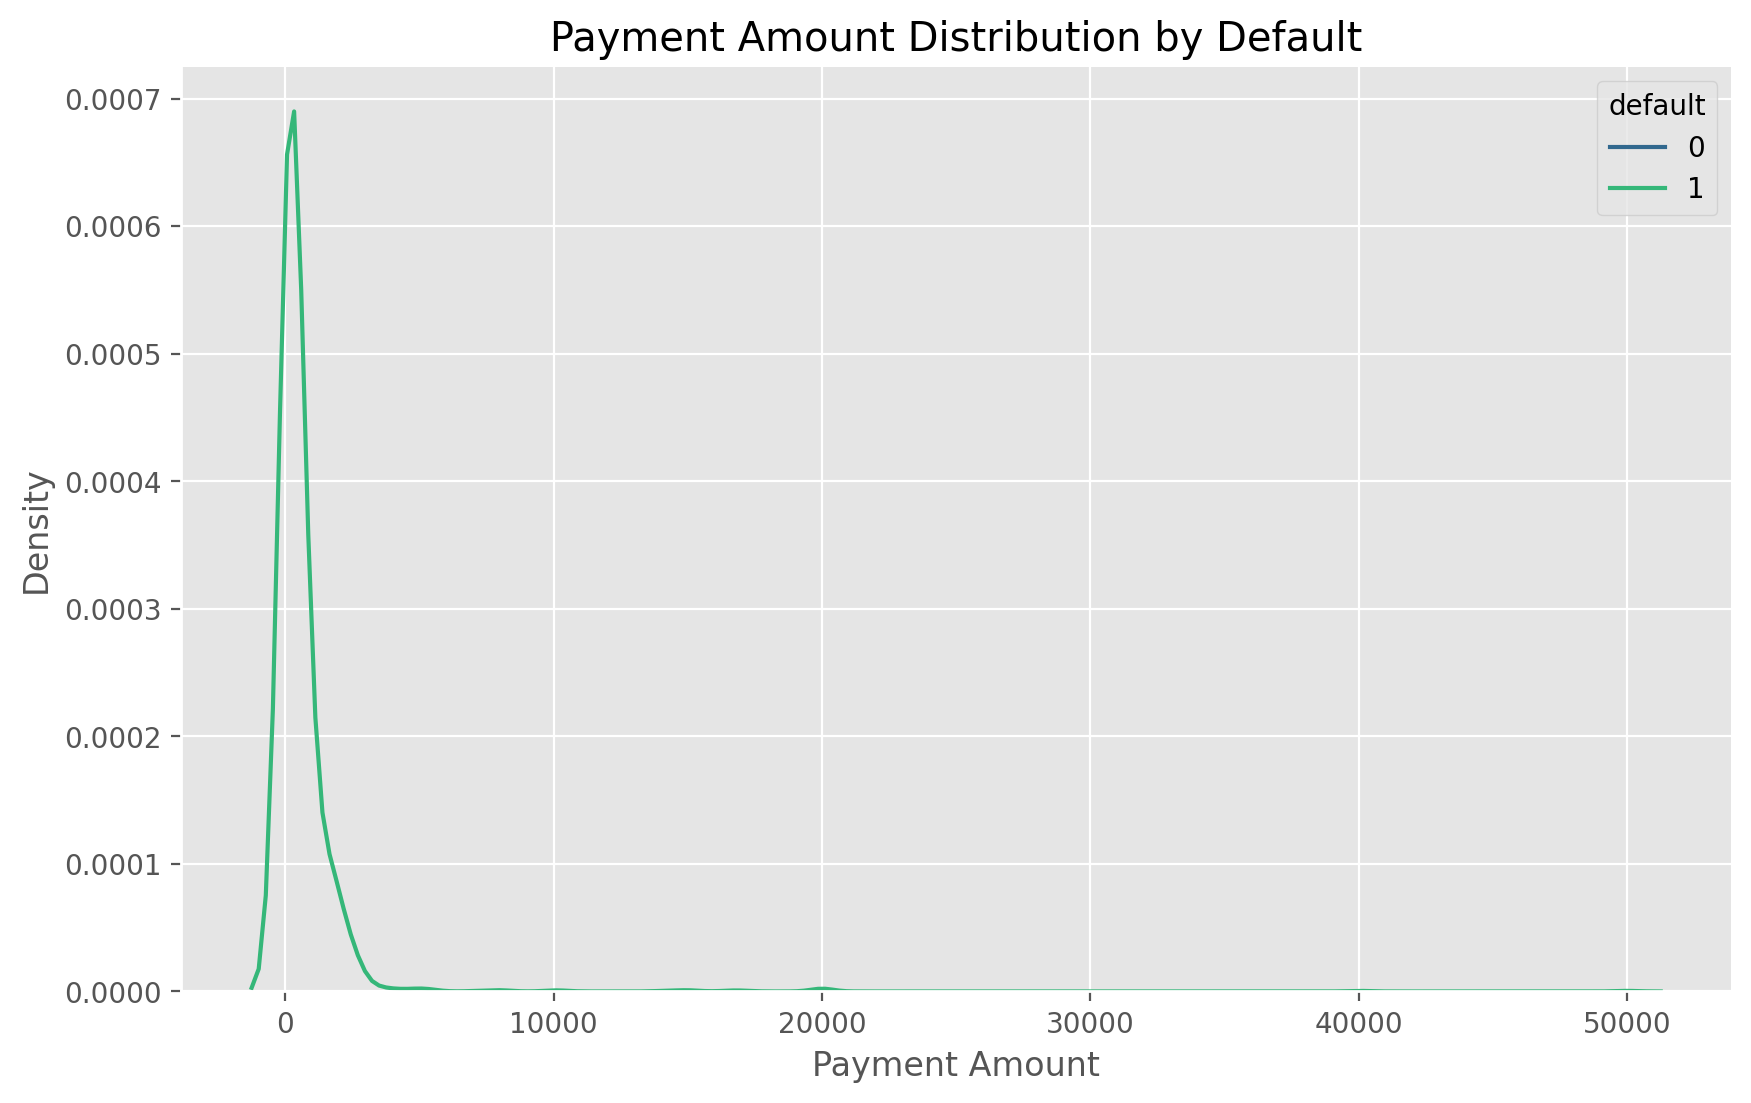

In [32]:
df['default'] = df.payment_code.apply(lambda x: 1 if x == 'DEFAULT' else 0)
df['default'] = df['default'].astype('category')
df['payment_amt'] = df['payment_amt'].astype('float')

max_default_payment_amt = df[df['default'] == 1]['payment_amt'].max()

df_filtered = df[df['payment_amt'] <= max_default_payment_amt]

plt.figure(figsize=(10,6))
sns.kdeplot(x='payment_amt', hue='default', data=df_filtered[df_filtered.default == 1],palette = palette)
plt.title('Payment Amount Distribution by Default')
plt.xlabel('Payment Amount')
plt.show()


<ipython-input-4-ef682a2ba7e8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='payment_code', y='entity_year_established', palette='viridis')


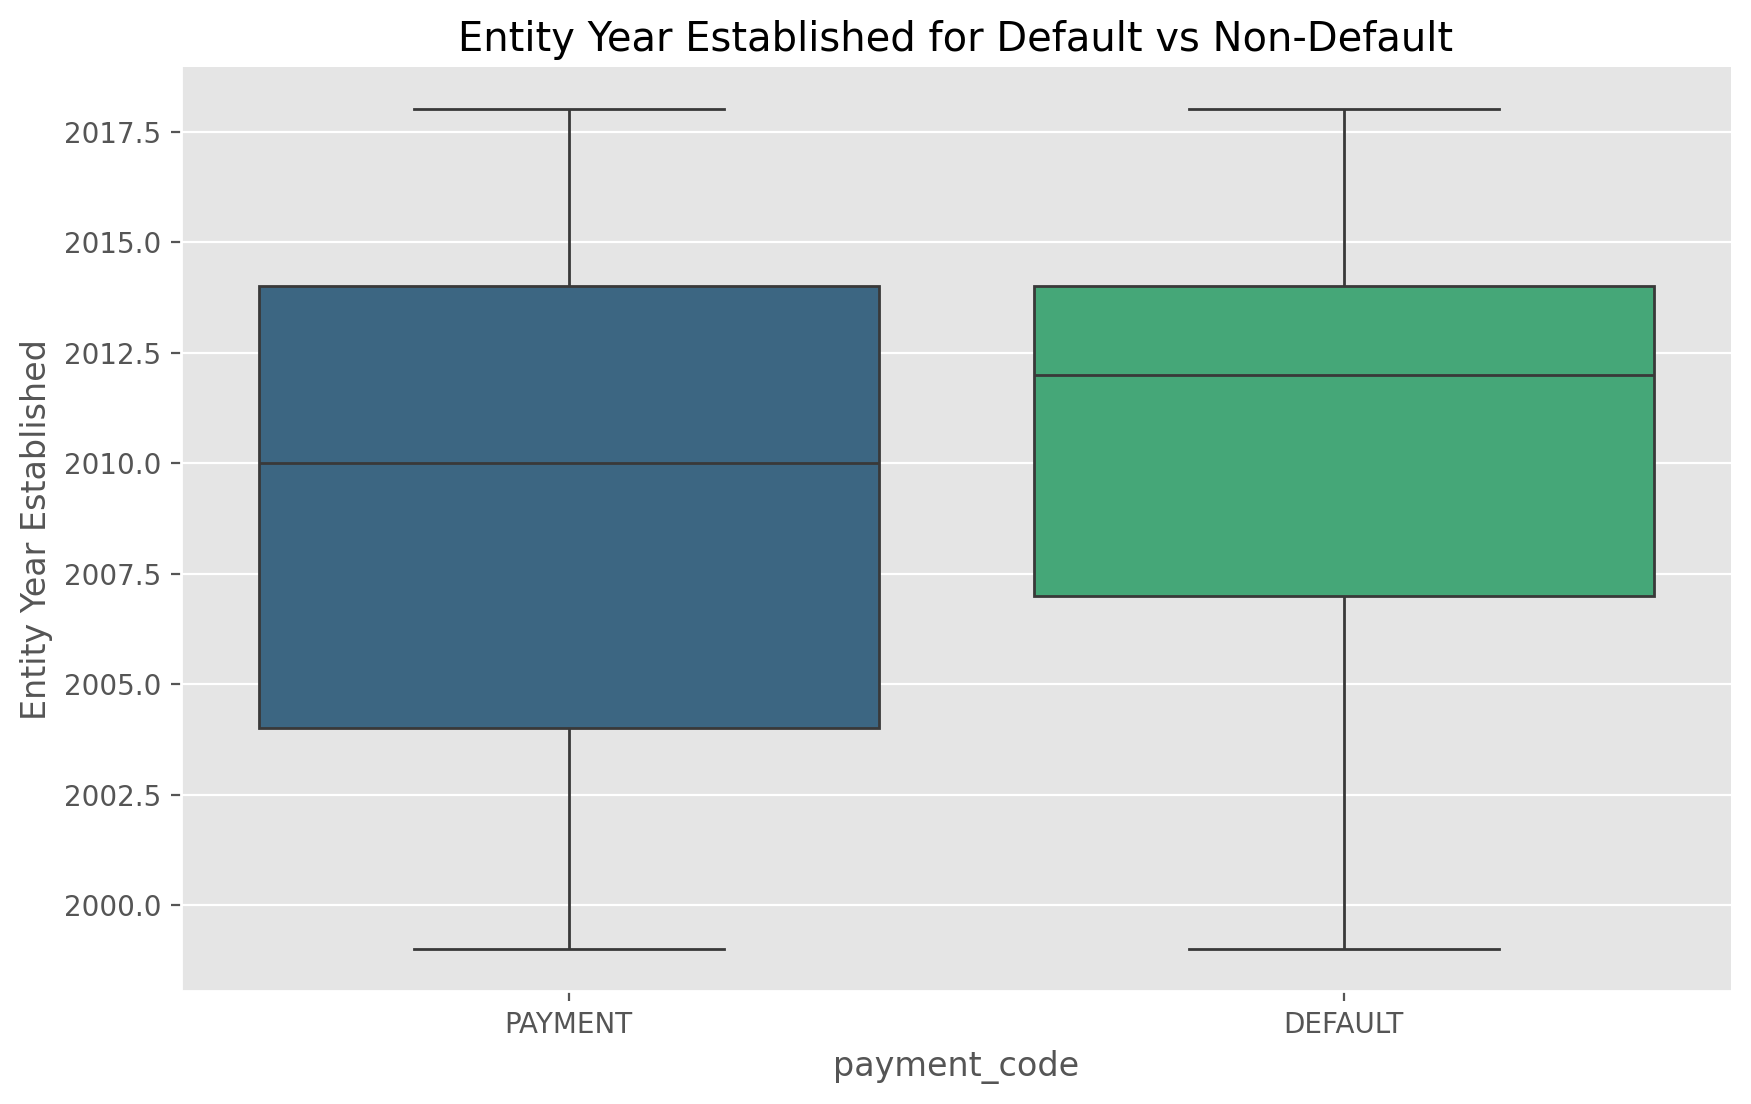

In [4]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='payment_code', y='entity_year_established', palette='viridis')
plt.ylabel('Entity Year Established')
plt.title('Entity Year Established for Default vs Non-Default')
plt.show()


<ipython-input-5-e7bc639d122b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportion.values, y=proportion.index,palette = 'viridis',edgecolor ='black')


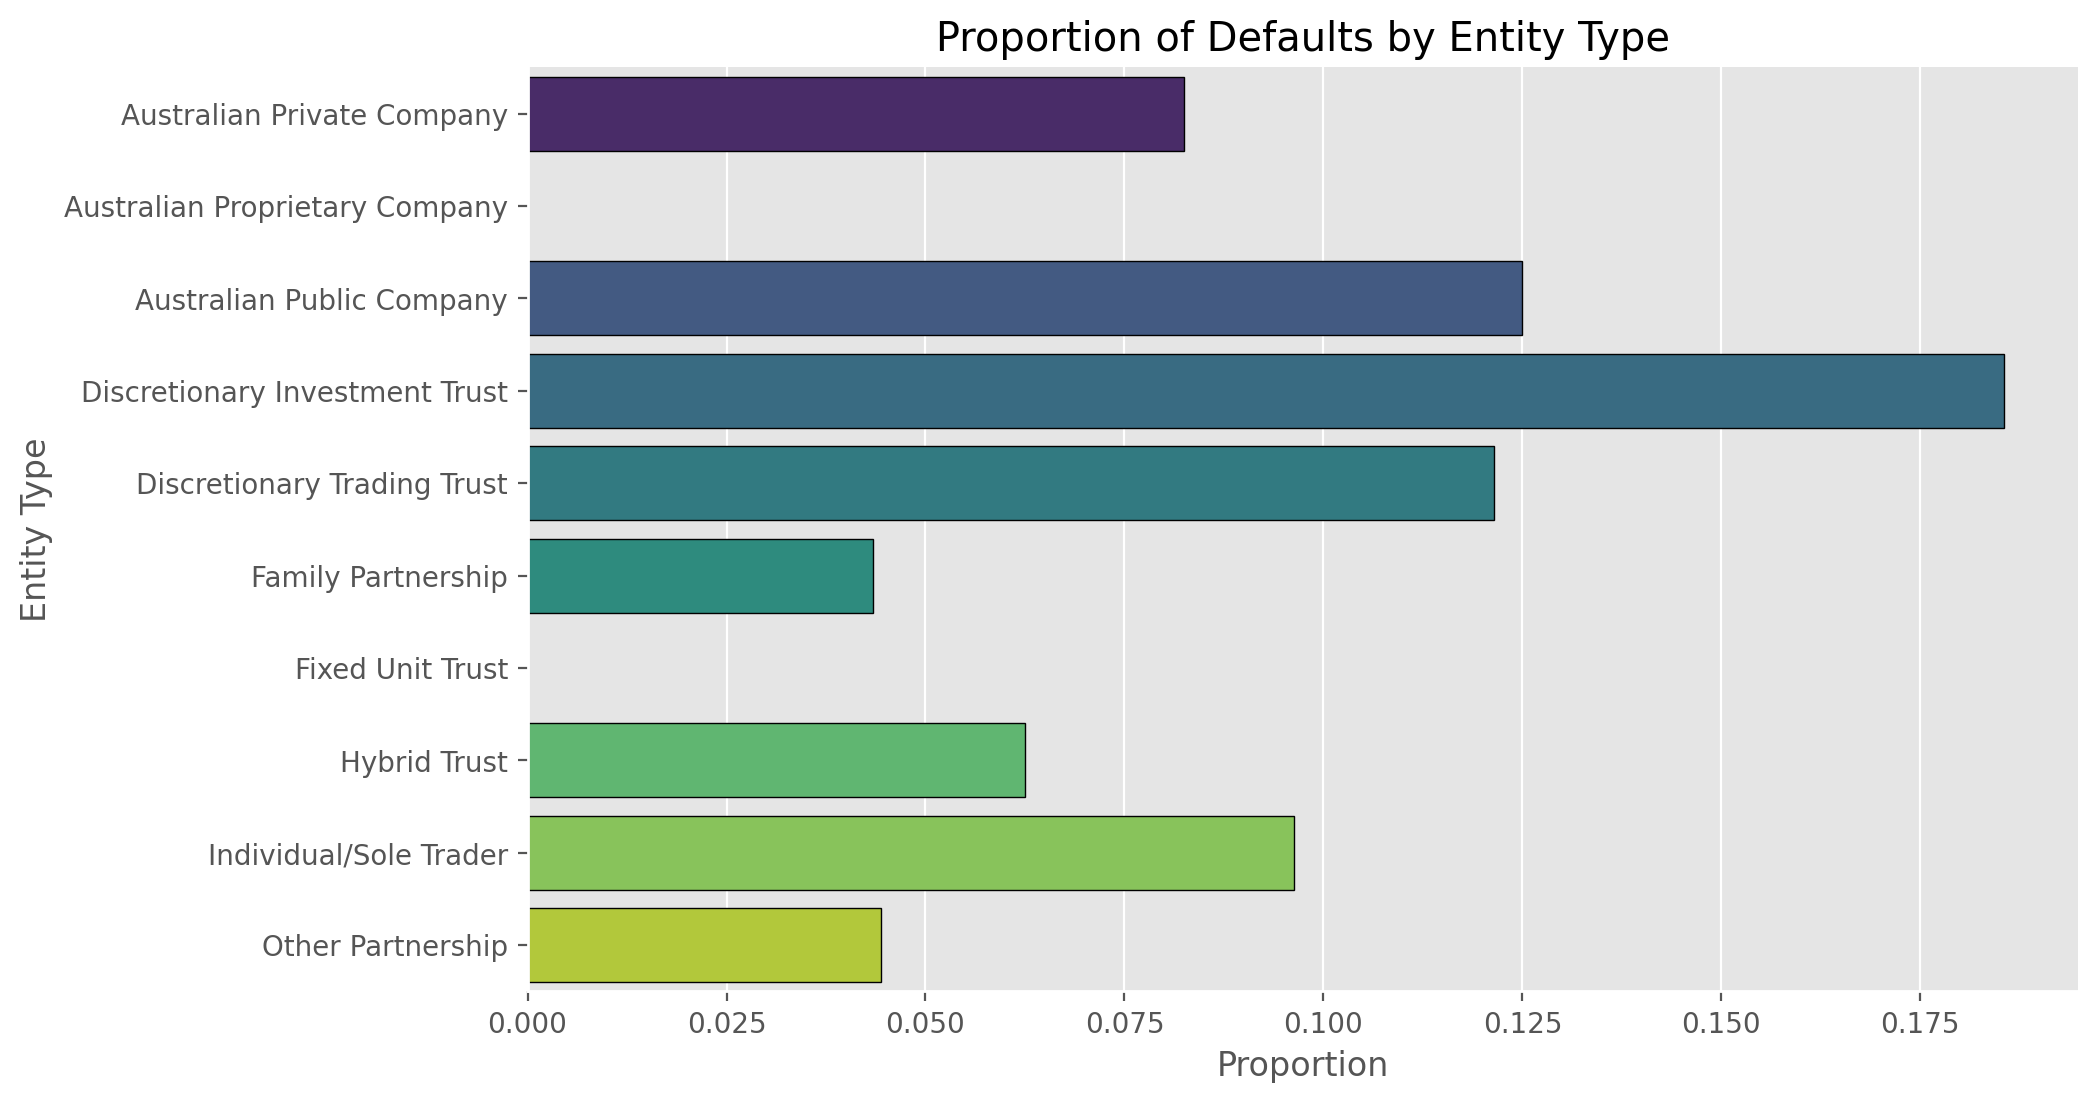

In [5]:

default = df[df.payment_code=='DEFAULT']['entity_type'].value_counts()
total = df['entity_type'].value_counts()
proportion = default/total

plt.figure(figsize=(10,6))
sns.barplot(x=proportion.values, y=proportion.index,palette = 'viridis',edgecolor ='black')
plt.title('Proportion of Defaults by Entity Type')
plt.xlabel('Proportion')
plt.ylabel('Entity Type')
plt.show()

<ipython-input-8-fb216bef9c36>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='payment_code',palette = palette,edgecolor='black')


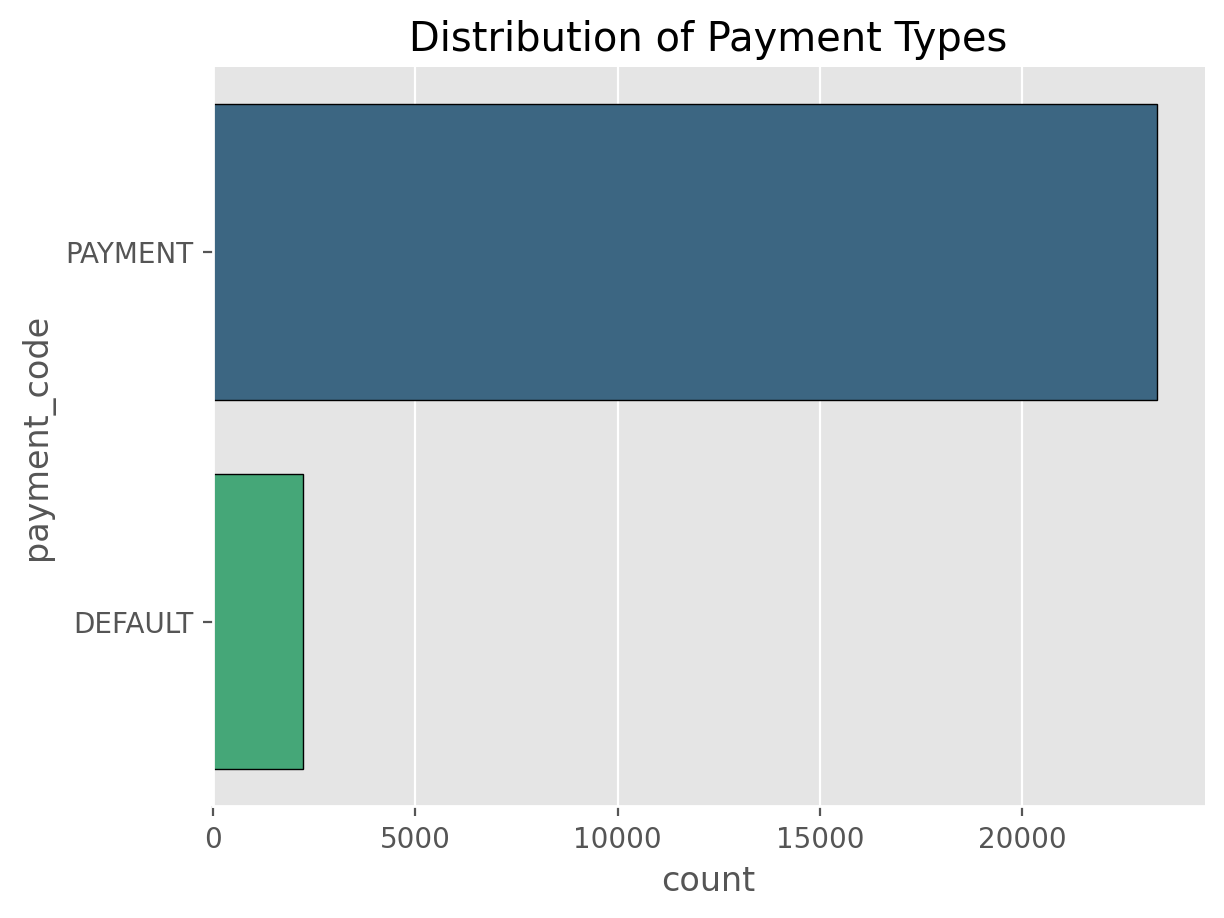

In [8]:

sns.countplot(data=df, y='payment_code',palette = palette,edgecolor='black')
plt.title('Distribution of Payment Types')
plt.show()

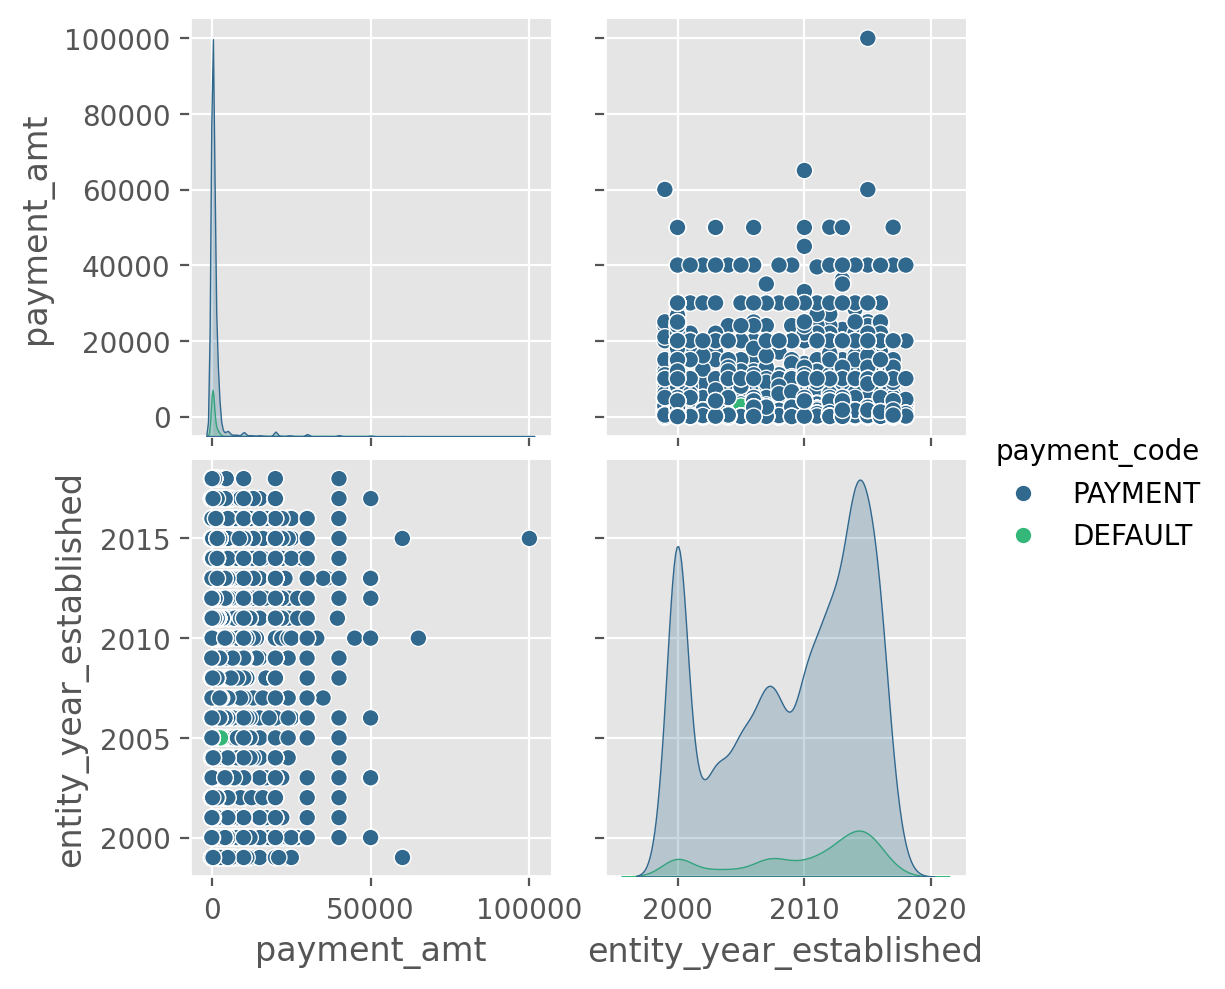

In [7]:
variables = ['payment_amt','entity_type','entity_year_established','payment_code']
sns.pairplot(df[variables], hue='payment_code',palette = 'viridis')


<ipython-input-22-f659bdf0a2b7>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df[df.payment_amt<=30000], x='payment_amt', palette=palette,bins=10)


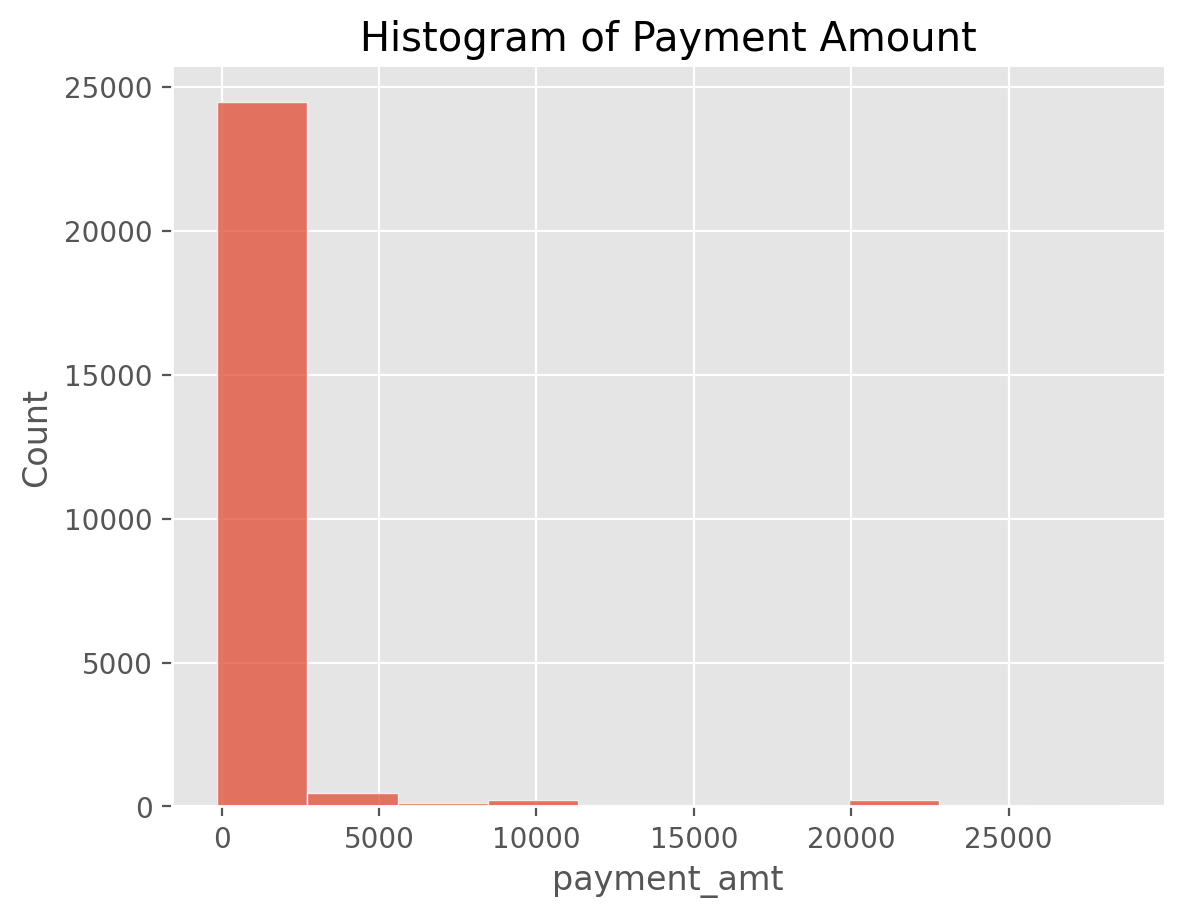

In [22]:

sns.histplot(data=df[df.payment_amt<=30000], x='payment_amt', palette=palette,bins=10)
plt.title('Histogram of Payment Amount')
plt.show()


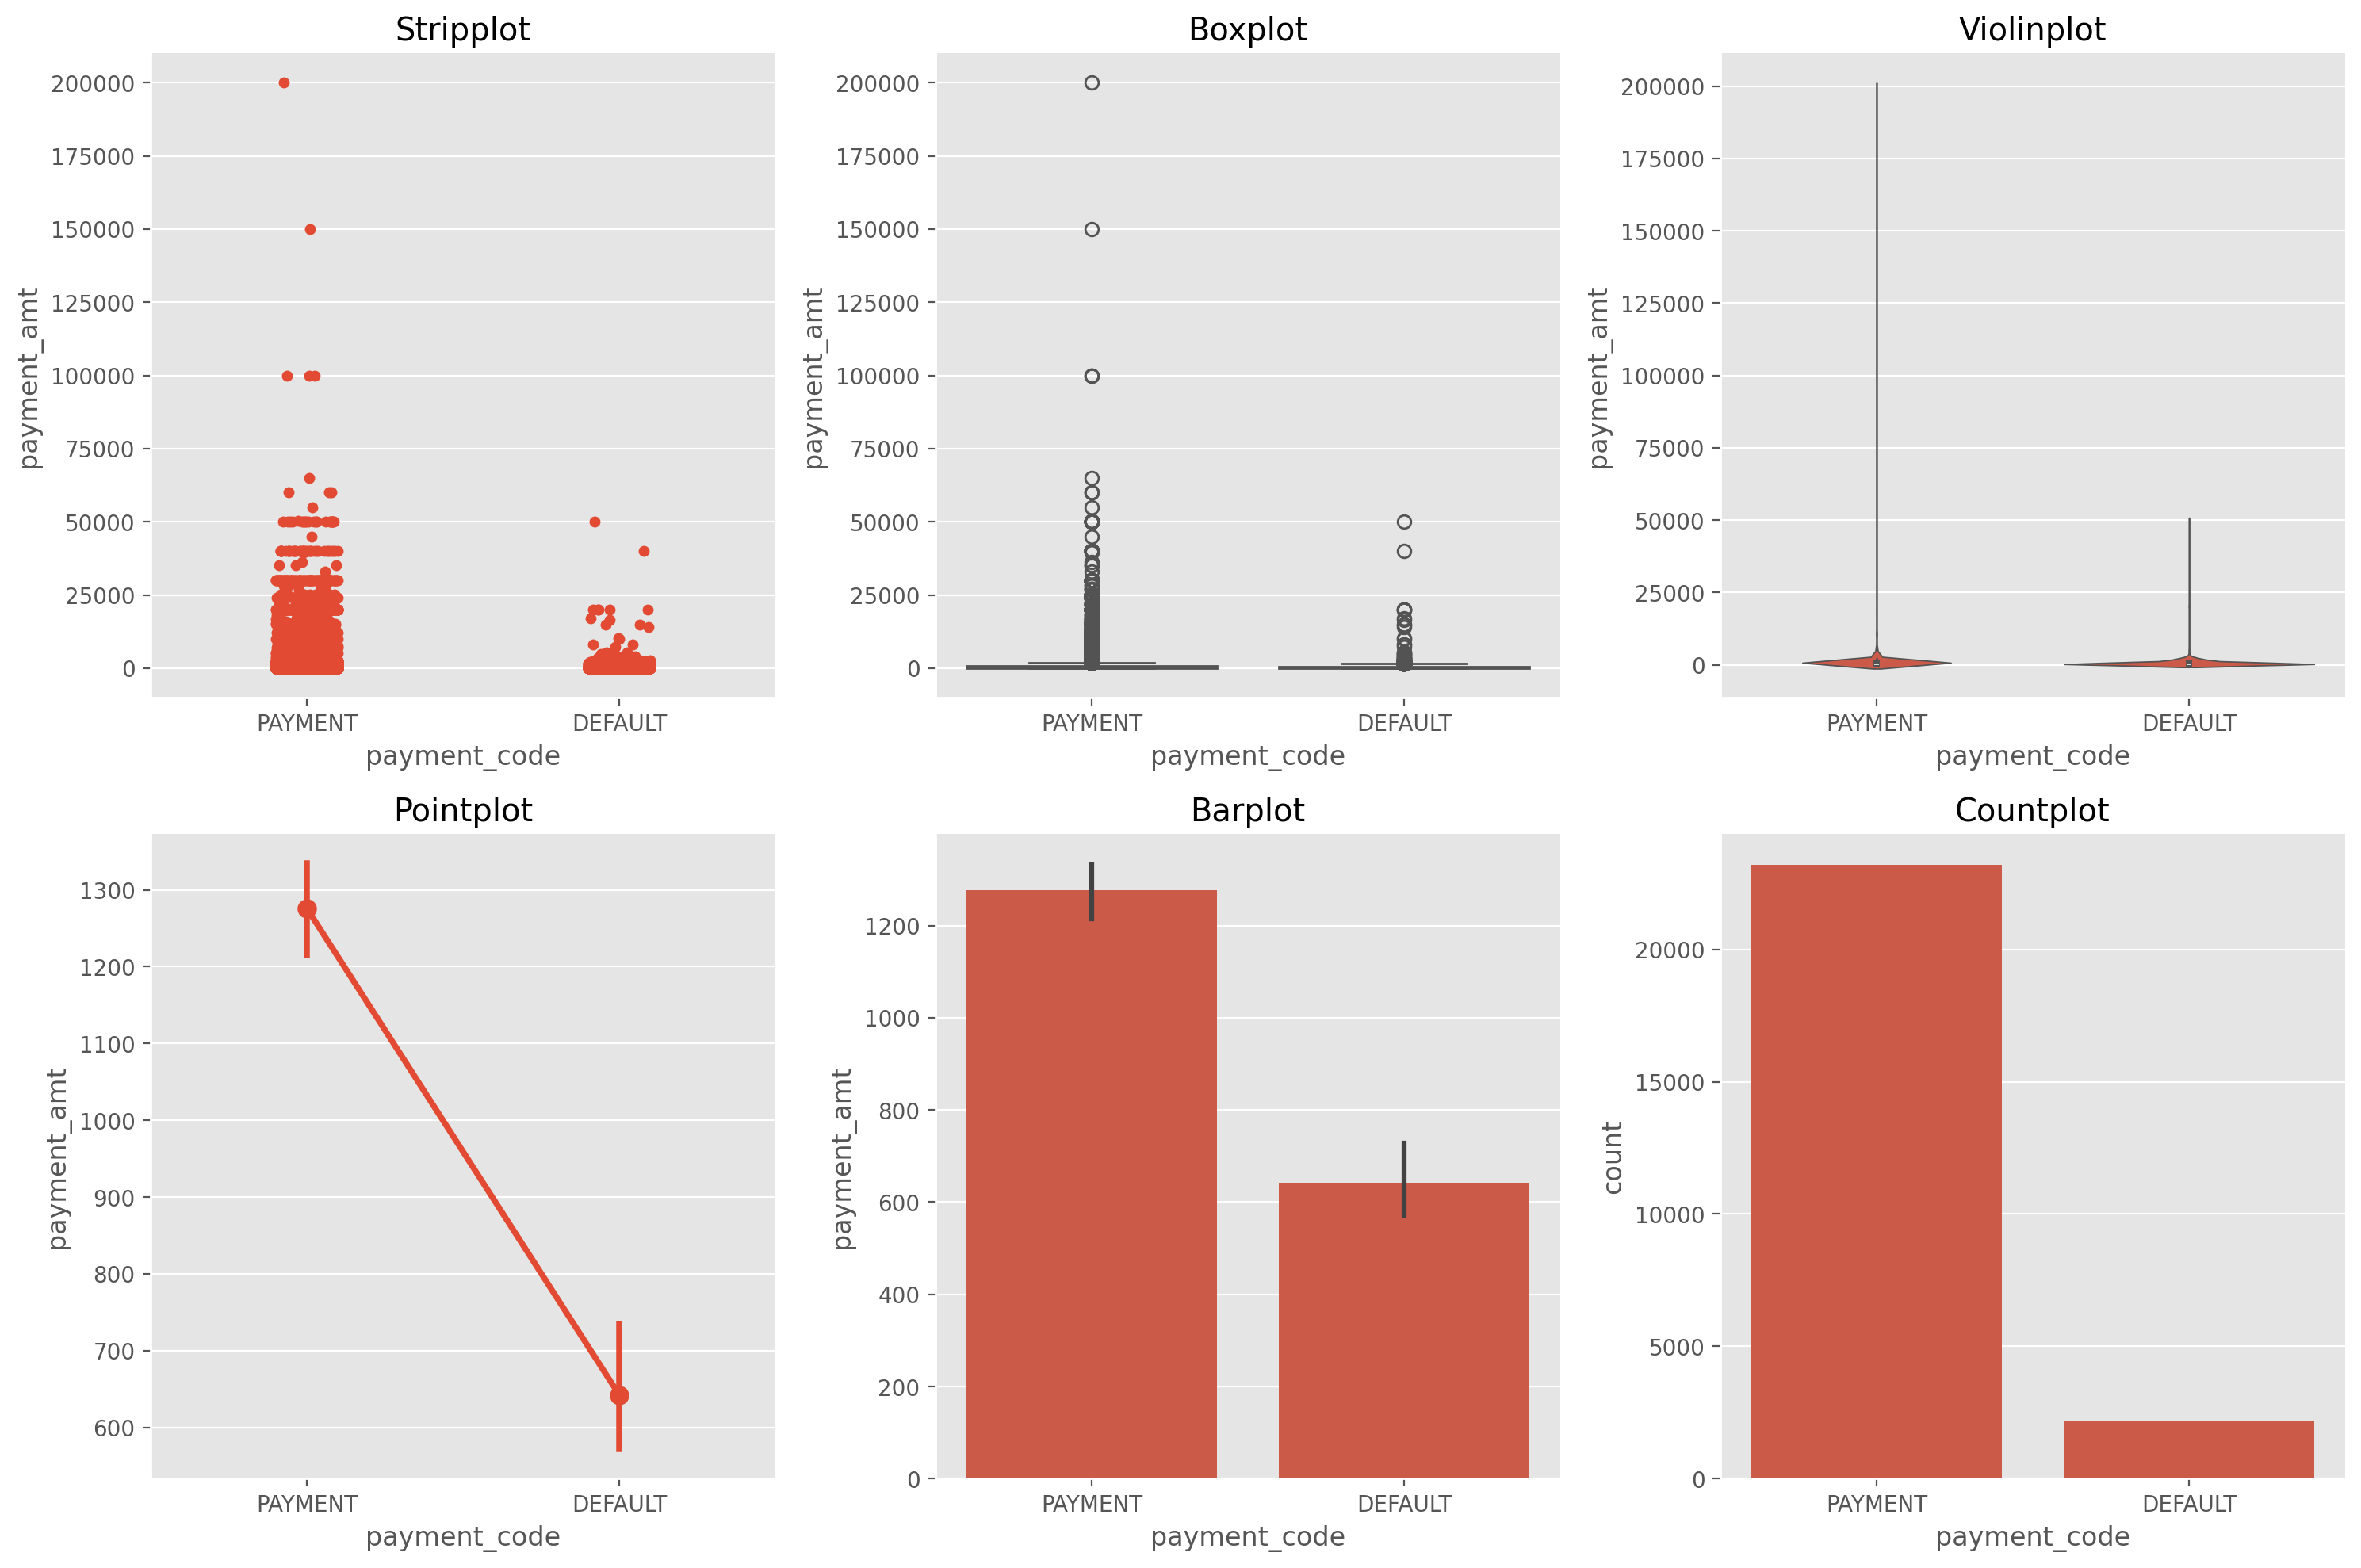

In [33]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Categorical scatterplots
sns.stripplot(x="payment_code", y="payment_amt", data=df, ax=axs[0, 0])
axs[0, 0].set_title('Stripplot')

# Categorical distribution plots
sns.boxplot(x="payment_code", y="payment_amt", data=df, ax=axs[0, 1])
axs[0, 1].set_title('Boxplot')

sns.violinplot(x="payment_code", y="payment_amt", data=df, ax=axs[0, 2])
axs[0, 2].set_title('Violinplot')

# Categorical estimate plots
sns.pointplot(x="payment_code", y="payment_amt", data=df, ax=axs[1, 0])
axs[1, 0].set_title('Pointplot')

sns.barplot(x="payment_code", y="payment_amt", data=df, ax=axs[1, 1])
axs[1, 1].set_title('Barplot')

sns.countplot(x="payment_code", data=df, ax=axs[1, 2])
axs[1, 2].set_title('Countplot')

plt.tight_layout()
plt.show()


### Logistic Regression Model
